In [1]:
import numpy as np
from scipy.signal import convolve2d
from time import time

import matplotlib.pyplot as plt

In [2]:
n_soldiers = 100
n_castles = 10

# helper functions

In [3]:
def random_allocation(n):
    return np.random.multinomial(
        n_soldiers, 
        np.ones(n_castles)/n_castles, 
        size=n
    )

def get_enemy_sample(n):
    return random_allocation(n)

def win_adjustment(wins):
    # applies rolling window sum for every sequence of 3 wins
    # when we see a 3 in conv, it means there were 3 wins in a row
    conv = convolve2d(wins, np.ones((1,3)), mode="full")
    # remove last 2 cols bc they are extra
    conv = conv[:,:-2]

    # gives index of first 3 in each row (if no 3, returns 0)
    idxs = np.argmax(conv == 3, axis=1)

    # cumulative sum of #3s per row
    # we only care if this is >0
    num_3s_per_row = np.cumsum(conv == 3, axis=1)

    # any castle after a 3rd win in a row is set to a True win
    wins[num_3s_per_row > 0] = True
    return wins

def calculate_wins(my_allocation, enemy_samples):
    # win if we have more troops
    mine_tiled = np.tile(my_allocation, enemy_samples.shape[0]).reshape(-1,n_castles)
    wins = my_allocation > enemy_samples
    losses = my_allocation < enemy_samples

    # change from boolean to +1 / -1 and set ties
    wins_int = wins * 2 - 1
    wins_int[wins == losses] = 0

    # handle 3 wins in a row
    wins_final = win_adjustment(wins_int)
    
    scores = wins_final @ np.arange(1,n_castles+1)
    return (scores > 0).mean()   # probability of win

# actual code

- Calculates 5000 random possible allocations of my troops
- For each allocation of my troops, calculates 5000 random allocations of enemy's troops and finds estimate of P(I win)

You could actually make this more efficient by using a 3d numpy array and doing all these operations across the 3rd axis, instead of using a for loop.

Moral of the story is you don't want to be running for loops in general.

In [4]:
n_enemy_samples = 10000
n_my_samples = 10000

win_probs = np.zeros(n_my_samples)
my_samples = np.zeros((n_my_samples, n_castles))

start = time()
for i in range(n_my_samples):
    mine = random_allocation(1)
    enemy_samples = random_allocation(n_enemy_samples)
    win_probs[i] = calculate_wins(mine, enemy_samples)
    my_samples[i] = mine

seconds = time() - start
print(f"{int(seconds // 60)} min, {int(seconds % 60)} sec")

3 min, 9 sec


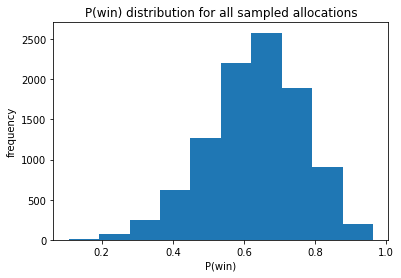

In [14]:
plt.hist(win_probs)
plt.title("P(win) distribution for all sampled allocations")
plt.xlabel("P(win)")
plt.ylabel("frequency")

plt.show()

Let's look at how sensitive our probability estimates are to whichever enemy samples we draw.

In [6]:
def sensitivity(alloc):
    win_probs = []
    for i in range(300):
        new_enemies = random_allocation(n_enemy_samples)
        new_prob = calculate_wins(alloc, new_enemies)
        win_probs.append(calculate_wins(alloc, new_enemies))
    return win_probs

In [7]:
best_allocation = my_samples[np.argmax(win_probs)]
second_best = my_samples[np.argsort(win_probs)[-2]]

In [8]:
best_prob = np.max(win_probs)
second_best_prob = np.sort(win_probs)[-2]

In [9]:
best_sensitivity = sensitivity(best_allocation)
second_sensitivity = sensitivity(second_best)

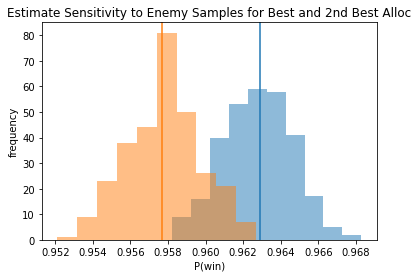

In [10]:
# look at sensitivity of our estimate to which enemy samples we draw

plt.hist(best_sensitivity, alpha=0.5)
plt.hist(second_sensitivity, alpha=0.5)

# plot estimates
plt.axvline(best_prob)
plt.axvline(second_best_prob, color="C1")

plt.title("Estimate Sensitivity to Enemy Samples for Best and 2nd Best Alloc")
plt.xlabel("P(win)")
plt.ylabel("frequency")

plt.show()

So based on the above, it looks like there might be some overlap, but on the whole we can generally trust our estimates.

But really this is a naive approach to this problem. This is called a **maximin** problem in game theory and optimization: you are trying to maximize your opponent's minimum score.

So you'd have to take into account all of your opponent's possible moves (assuming that they're rational). In this notebook, we've assumed that the enemy chooses a random allocation of troops. Instead, they're choosing an optimal strategy for themselves. So, you need to choose an optimal strategy that takes into account that **your enemy is choosing their own optimal strategy**, which is where this gets complicated. 

[Here](https://www.youtube.com/watch?v=2frw1TarJuQ) is a good video (8 min) with more information on game theory.

And if you don't have it already, I use [this](https://chrome.google.com/webstore/detail/remove-youtube-recommende/khncfooichmfjbepaaaebmommgaepoid?hl=en) to get rid of YouTube clickbait.